## IDEAS
#### Choosing municipality:
- Choose longest one
- Choose less missing one

#### Handling Missing Values:
- Dropping
- If there's a single value missing in a particular hour: Copy other
- If both of values are missing in a particular hour: Spline, find best one on longest uninterrupted sequence.

#### Feature engineering:
- Statistical features on two value of a particular hour (min, max, differences ...)
- Statistical features on a time window (min, max, differences, fourier stats, special indexes...)
- Bolinger bands (outliers)
- EWMA crossover points
- diff, pct_change
- date-related features: weekday, season, month etc.

#### Dimensionality reduction:
- Feature importance with pearson's correlation
- Multicollinearity

#### Models:
- Logistic regression as baseline with all features
- XGBoost with all features
- ARIMA or Prophet on a single feature
- LSTM on a single feature

#### Prediction Strategies:
- Static-Dynamic

In [1]:
# necessary libraries
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks

# 1. EXPLORATORY DATA ANALYSIS

In [2]:
# reading data
data = pd.read_csv("../input/piworksbus/municipality_bus_utilization.csv")
data.head(20)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
5,2017-06-04 07:59:42,5,70,587
6,2017-06-04 07:59:42,2,273,697
7,2017-06-04 07:59:42,1,129,397
8,2017-06-04 07:59:42,6,597,3113
9,2017-06-04 07:59:42,3,623,1930


In [3]:
# datatypes and null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


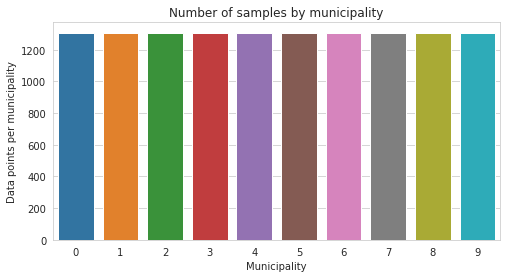

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of data points in municipality 9 = 1307 ~ 10.0%
Number of data points in municipality 8 = 1307 ~ 10.0%
Number of data points in municipality 4 = 1307 ~ 10.0%
Number of data points in municipality 0 = 1307 ~ 10.0%
Number of data points in municipality 7 = 1307 ~ 10.0%
Number of data points in municipality 5 = 1307 ~ 10.0%
Number of data points in municipality 2 = 1307 ~ 10.0%
Number of data points in municipality 1 = 1307 ~ 10.0%
Number of data points in municipality 6 = 1307 ~ 10.0%
Number of data points in municipality 3 = 1307 ~ 10.0%
--------------------------------------------------
total datapoints: 13070


In [4]:
# analysis of sample counts
count_dict = dict(data['municipality_id'].value_counts())

sns.set_style("whitegrid")
plt.figure(figsize = (8, 4))
sns.barplot(x = list(count_dict.keys()), y = list(count_dict.values()))
plt.xlabel('Municipality')
plt.ylabel('Data points per municipality')
plt.title('Number of samples by municipality')
plt.show()

# Percentage-wise distribution of municipalities
print("- "* 50)
for i in count_dict.keys():
  print("Number of data points in municipality {0} = {1} ~ {2}%".format(
  i, count_dict[i], round((count_dict[i]*100)/sum(count_dict.values()), 2)))

print("-"*50)
print("total datapoints:", sum(count_dict.values()))

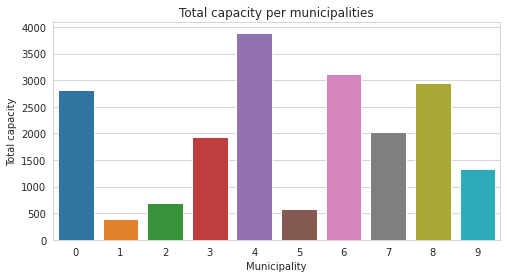

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total capacity of the municipality 0 = 2813 ~ 14.26%
Total capacity of the municipality 1 = 397 ~ 2.01%
Total capacity of the municipality 2 = 697 ~ 3.53%
Total capacity of the municipality 3 = 1930 ~ 9.78%
Total capacity of the municipality 4 = 3893 ~ 19.73%
Total capacity of the municipality 5 = 587 ~ 2.98%
Total capacity of the municipality 6 = 3113 ~ 15.78%
Total capacity of the municipality 7 = 2019 ~ 10.23%
Total capacity of the municipality 8 = 2947 ~ 14.94%
Total capacity of the municipality 9 = 1332 ~ 6.75%
--------------------------------------------------
total capacity: 19728


In [5]:
# Usage analysis
sns.set_style("whitegrid")
plt.figure(figsize = (8, 4))
sns.barplot(x = data["municipality_id"], y = data["total_capacity"])
plt.xlabel('Municipality')
plt.ylabel('Total capacity')
plt.title('Total capacity per municipalities')
plt.show()

# Percentage-wise distribution of total capacities
print("- "* 50)
capacities = data[["municipality_id", "total_capacity"]].drop_duplicates().sort_values("municipality_id")
for i in capacities.iterrows():
    print("Total capacity of the municipality {} = {} ~ {}%".format(
        i[1]["municipality_id"], i[1]["total_capacity"], round((i[1]["total_capacity"]*100)/sum(capacities["total_capacity"]), 2)))
   # print(i, type(i))
print("-"*50)
print("total capacity:", sum(capacities["total_capacity"]))

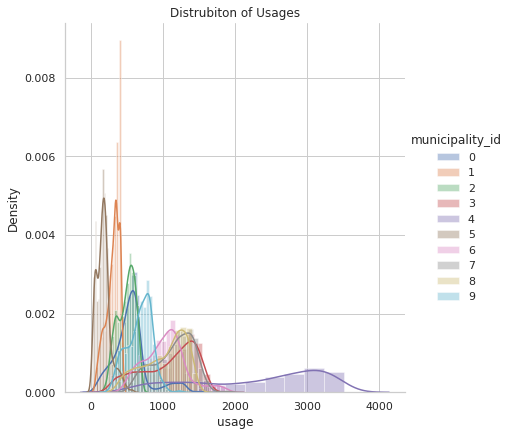

In [6]:
# Analysis of usages
sns.set(style = 'whitegrid')
sns.FacetGrid(data, hue = 'municipality_id', height=6).map(sns.distplot, 'usage').add_legend()
plt.title('Distrubiton of Usages')
plt.show()

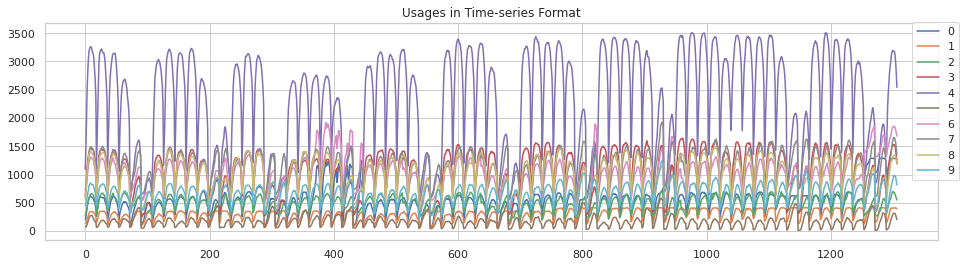

In [7]:
# Usage in time-series
plt.figure(figsize = (16, 4))
for i in range(10):
    plt.plot(data[data['municipality_id'] == i][['usage']].reset_index(drop=True), label=i)
plt.legend(loc='lower right',bbox_to_anchor=(1.03, 0.25))
plt.title('Usages in Time-series Format')
plt.show()

Pink one (municipality_id=6) is chosen for next steps, due to it's normal distrubiton and irregular seasonality.

# 2. PREPROCESSING

### 2.1. Handling missing hours

In [8]:
# Choose municipality 6
mun_6 = data[data['municipality_id'] == 6].reset_index(drop=True)
len(mun_6)

1307

In [9]:
# Create columns based on hour and day
mun_6["timestamp_til_hour"] = mun_6["timestamp"].apply(lambda x: x[:-6])
mun_6["timestamp_til_day"] = mun_6["timestamp"].apply(lambda x: x[:-9])

In [10]:
# number of days in dataset
mun_6_daycount = mun_6.groupby("timestamp_til_day").count()
print("number of days in dataset:", len(mun_6_daycount))

# hour counts of days
mun_6_daycount_sorted = mun_6_daycount.sort_values("usage")
print("Hour counts:")
mun_6_daycount_sorted["usage"].value_counts()

number of days in dataset: 72
Hour counts:


18    66
17     5
34     1
Name: usage, dtype: int64

In [11]:
# find irregular days for municipality 6
irregular_days = mun_6_daycount_sorted[mun_6_daycount_sorted["usage"]!=18].index.to_list()
print("irregular days:")
print(irregular_days)

# empty hours for the day with 34 measurements
mun_6[mun_6["timestamp_til_day"]==irregular_days[5]]

irregular days:
['2017-07-25', '2017-06-28', '2017-08-14', '2017-08-13', '2017-07-18', '2017-06-30']


,timestamp,municipality_id,usage,total_capacity,timestamp_til_hour,timestamp_til_day
431,2017-06-30 07:59:55,6,666,3113,2017-06-30 07,2017-06-30
432,2017-06-30 08:25:53,6,670,3113,2017-06-30 08,2017-06-30
433,2017-06-30 08:59:52,6,665,3113,2017-06-30 08,2017-06-30
434,2017-06-30 09:25:57,6,665,3113,2017-06-30 09,2017-06-30
435,2017-06-30 09:59:52,6,667,3113,2017-06-30 09,2017-06-30
436,2017-06-30 10:25:54,6,680,3113,2017-06-30 10,2017-06-30
437,2017-06-30 10:59:56,6,694,3113,2017-06-30 10,2017-06-30
438,2017-06-30 11:25:55,6,710,3113,2017-06-30 11,2017-06-30
439,2017-06-30 11:59:58,6,777,3113,2017-06-30 11,2017-06-30
440,2017-06-30 12:26:54,6,845,3113,2017-06-30 12,2017-06-30


In [12]:
# find hour counts of all municipalities
def hour_counts_in_days(mun_id):
    mun_data = data[data['municipality_id'] == mun_id].reset_index(drop=True)
    mun_data["timestamp_til_hour"] = mun_data["timestamp"].apply(lambda x: x[:-6])
    mun_data["timestamp_til_day"] = mun_data["timestamp"].apply(lambda x: x[:-9])
    mun_daycount = mun_data.groupby("timestamp_til_day").count()
    # hour counts of days
    print("municipality id: ", mun_id)
    print(mun_daycount["usage"].value_counts())
    # print irregular days
    print("irregular days:")
    print(mun_daycount[mun_daycount["usage"]!=18].index.to_list())
    
for i in range(10):
    hour_counts_in_days(i)
    print("----------------")

municipality id:  0
18    66
17     5
34     1
Name: usage, dtype: int64
irregular days:
['2017-06-28', '2017-06-30', '2017-07-18', '2017-07-25', '2017-08-13', '2017-08-14']
----------------
municipality id:  1
18    66
17     5
34     1
Name: usage, dtype: int64
irregular days:
['2017-06-28', '2017-06-30', '2017-07-18', '2017-07-25', '2017-08-13', '2017-08-14']
----------------
municipality id:  2
18    66
17     5
34     1
Name: usage, dtype: int64
irregular days:
['2017-06-28', '2017-06-30', '2017-07-18', '2017-07-25', '2017-08-13', '2017-08-14']
----------------
municipality id:  3
18    66
17     5
34     1
Name: usage, dtype: int64
irregular days:
['2017-06-28', '2017-06-30', '2017-07-18', '2017-07-25', '2017-08-13', '2017-08-14']
----------------
municipality id:  4
18    66
17     5
34     1
Name: usage, dtype: int64
irregular days:
['2017-06-28', '2017-06-30', '2017-07-18', '2017-07-25', '2017-08-13', '2017-08-14']
----------------
municipality id:  5
18    66
17     5
34     

They all have same bus utilization hours and it seems like all measurements are done between aproximately **08:00 - 16:30** including irregular days.

To my point of view, missing hours can be neglected since municipalities have the same pattern. But we may need to handle missing measurements in hours depending on the method we use to choose the signature measurement for that particular hour.

### 2.2. Handling missing measurements in hours

In [13]:
# Find irregular hourly measurements
mun_6_hourcount = mun_6.groupby("timestamp_til_hour").count()
mun_6_hourcount[mun_6_hourcount["usage"]!=2]

,timestamp,municipality_id,usage,total_capacity,timestamp_til_day
timestamp_til_hour,,,,,
2017-06-04 07,1,1,1,1,1
2017-06-04 12,1,1,1,1,1
2017-06-04 14,3,3,3,3,3
2017-06-04 15,1,1,1,1,1
2017-06-05 07,1,1,1,1,1
...,...,...,...,...,...
2017-08-18 13,1,1,1,1,1
2017-08-18 14,3,3,3,3,3
2017-08-18 15,1,1,1,1,1


In [14]:
# 13th hour of 2017-06-30 has 6 measurements
mun_6[mun_6["timestamp_til_hour"]=="2017-06-30 13"]

,timestamp,municipality_id,usage,total_capacity,timestamp_til_hour,timestamp_til_day
441,2017-06-30 13:06:59,6,1030,3113,2017-06-30 13,2017-06-30
442,2017-06-30 13:25:59,6,1153,3113,2017-06-30 13,2017-06-30
443,2017-06-30 13:59:59,6,1435,3113,2017-06-30 13,2017-06-30
457,2017-06-30 13:00:06,6,1162,3113,2017-06-30 13,2017-06-30
458,2017-06-30 13:26:01,6,1170,3113,2017-06-30 13,2017-06-30
459,2017-06-30 13:59:47,6,1152,3113,2017-06-30 13,2017-06-30


In [15]:
# find hourly measurement counts of all municipalities
def measurement_counts_in_hours(mun_id):
    mun_data = data[data['municipality_id'] == mun_id].reset_index(drop=True)
    mun_data["timestamp_til_hour"] = mun_data["timestamp"].apply(lambda x: x[:-6])
    mun_data["timestamp_til_day"] = mun_data["timestamp"].apply(lambda x: x[:-9])
    mun_hourcount = mun_data.groupby("timestamp_til_hour").count()
    # hour counts of days
    print("municipality id: ", mun_id)
    print("Total number of hours: ", len(mun_hourcount))
    print(mun_hourcount["usage"].value_counts())
    # print irregular hours
    irregular_hours = mun_hourcount[mun_hourcount["usage"]!=2].index.to_list()
    print("irregular hours: ", len(irregular_hours))
    #print(irregular_hours)
    

for i in range(10):
    measurement_counts_in_hours(i)
    print("----------------")

municipality id:  0
Total number of hours:  674
2    451
1    136
3     81
4      5
6      1
Name: usage, dtype: int64
irregular hours:  223
----------------
municipality id:  1
Total number of hours:  674
2    451
1    136
3     81
4      5
6      1
Name: usage, dtype: int64
irregular hours:  223
----------------
municipality id:  2
Total number of hours:  674
2    451
1    136
3     81
4      5
6      1
Name: usage, dtype: int64
irregular hours:  223
----------------
municipality id:  3
Total number of hours:  674
2    451
1    136
3     81
4      5
6      1
Name: usage, dtype: int64
irregular hours:  223
----------------
municipality id:  4
Total number of hours:  674
2    451
1    136
3     81
4      5
6      1
Name: usage, dtype: int64
irregular hours:  223
----------------
municipality id:  5
Total number of hours:  674
2    451
1    136
3     81
4      5
6      1
Name: usage, dtype: int64
irregular hours:  223
----------------
municipality id:  6
Total number of hours:  674
2   

It seems like all municipalities have the same pattern on  hours with missing measurements. 

Let's examine if all measurements are done at exactly the same timestamps for all municipalities. 

In [16]:
# group timestamps to see if they have 10 municipalities or not
data_grouped = data.groupby("timestamp").count()
data_grouped[data_grouped["usage"]!=10]

,municipality_id,usage,total_capacity
timestamp,,,
2017-06-16 14:27:13,1,1,1
2017-06-16 14:34:14,9,9,9
2017-08-11 08:19:39,1,1,1
2017-08-11 08:25:43,9,9,9


In [17]:
# lets see these timestamps
data[data["timestamp"].isin(["2017-06-16 14:27:13","2017-08-11 08:19:39"])]

,timestamp,municipality_id,usage,total_capacity
2290,2017-06-16 14:27:13,5,189,587
11480,2017-08-11 08:19:39,3,313,1930


We can conclude that all measurements had done at exactly the same timestamps except for only two measurements belonging municipality 5 and 3. These exceptions and missing timestamps with 9 counts belong to same hours so we can ignore them when we resample data by hourly basis.

In conclusion, **it's not necessary to impute missing hours or days since all municipalities have almost the same missing patterns.** We will continue with municipality 6.

# 3. FEATURE ENGINEERING

### 3.1. Resampling data in hourly basis
It's possible to use minimum, average, differences, ratio to total_capacity etc. but it's not a valid way since the maximum usage will be used as target label and it will cause information leak otherwise.

In [18]:
# create a column by taking maximum of usages in a hour
hourly_min = mun_6.groupby("timestamp_til_hour").max("usage")["usage"]
mun_6 = mun_6.merge(hourly_min, how="left", left_on="timestamp_til_hour", 
            right_on="timestamp_til_hour", suffixes=[None, "_max"])

mun_6.head(5)

,timestamp,municipality_id,usage,total_capacity,timestamp_til_hour,timestamp_til_day,usage_max
0,2017-06-04 07:59:42,6,597,3113,2017-06-04 07,2017-06-04,597
1,2017-06-04 08:25:42,6,687,3113,2017-06-04 08,2017-06-04,801
2,2017-06-04 08:59:42,6,801,3113,2017-06-04 08,2017-06-04,801
3,2017-06-04 09:32:46,6,941,3113,2017-06-04 09,2017-06-04,1061
4,2017-06-04 09:59:48,6,1061,3113,2017-06-04 09,2017-06-04,1061


In [19]:
# Converting the column to DateTime format
mun_6["timestamp"] = pd.to_datetime(mun_6["timestamp_til_hour"], format='%Y-%m-%d %H')

# drop unnecesary columns
mun_6.drop(columns=["usage", "timestamp_til_day", "timestamp_til_hour",
                    "municipality_id", "total_capacity"], inplace=True)

# drop duplicates
mun_6.drop_duplicates(inplace=True)

# set index
mun_6 = mun_6.set_index('timestamp')
mun_6

,usage_max
timestamp,
2017-06-04 07:00:00,597
2017-06-04 08:00:00,801
2017-06-04 09:00:00,1061
2017-06-04 10:00:00,1219
2017-06-04 11:00:00,1297
...,...
2017-08-19 12:00:00,1787
2017-08-19 13:00:00,1845
2017-08-19 14:00:00,1853


### 3.2. Features based on date
Utilization may depend on weekday or weekend, month or week so they are given as features.

In [20]:
# Create new date-related features
dates = mun_6.index.values
mun_6['date_month'] = pd.Series(dates).apply(lambda x: x.month).values
mun_6['date_day'] = pd.Series(dates).apply(lambda x: x.day).values
mun_6['date_week_of_year'] = pd.Series(dates).apply(lambda x: x.weekofyear).values
mun_6["date_weekday"]= pd.Series(dates).apply(lambda x: x.isoweekday()).values

In [21]:
# Examine weekly trends
weekly_counts = mun_6.groupby("date_weekday").count()["usage_max"]
weekly_counts

date_weekday
1     93
2     95
3     93
4     95
5     92
6    104
7    102
Name: usage_max, dtype: int64

In [22]:
# average measurement in a week
avg_week = weekly_counts.mean()
print("average measurement count in a week: ", avg_week)

average measurement count in a week:  96.28571428571429


### 3.3. Features based on adjacency: Difference and percentage change 

Calculate difference and percentage change on hour-to-hour, day-to-day and week-to-week basis.  
https://towardsdatascience.com/data-analysis-visualization-in-finance-technical-analysis-of-stocks-using-python-269d535598e4

In [23]:
# hour to hour change
mun_6["Diff_h2h"] = mun_6["usage_max"].diff()*100

# day to day change
mun_6["Diff_d2d"] = mun_6["usage_max"].diff(periods=18)*100

# week to week change
mun_6["Diff_w2w"] = mun_6["usage_max"].diff(periods=96)*100

In [24]:
# hour to hour percentage change
mun_6["Perc_change_h2h"] = mun_6["usage_max"].pct_change()*100

# day to day percentage change
mun_6["Perc_change_d2d"] = mun_6["usage_max"].pct_change(periods=18)*100

# week to week percentage change
mun_6["Perc_change_w2w"] = mun_6["usage_max"].pct_change(periods=96)*100

### 3.4. Features based on time window: Crossover strategy

Calculate buy and sell points depending on slow and fast reactions (short-term and long-term moving averages) of the market.
https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a

In [25]:
# Create 18 hours (1 day) exponential moving average column
mun_6['18_ewm'] = mun_6['usage_max'].ewm(span = 18, adjust = False).mean()

# Create 96 hours (1 week) exponential moving average column
mun_6['96_ewm'] = mun_6['usage_max'].ewm(span = 96, adjust = False).mean()

# create a new column 'Signal' such that if 18 EWM is greater   
# than 96 EWM then set Signal as 1 else 0
mun_6['Signal'] = 0.0  
mun_6['Signal'] = np.where(mun_6['18_ewm'] > mun_6['96_ewm'], 1.0, 0.0)

# create a new column 'Position' which is a day-to-day difference of 
# the 'Signal' column
mun_6['Buy_sell_pts'] = mun_6['Signal'].diff()
mun_6.head(5)

,usage_max,date_month,date_day,date_week_of_year,date_weekday,Diff_h2h,Diff_d2d,Diff_w2w,Perc_change_h2h,Perc_change_d2d,Perc_change_w2w,18_ewm,96_ewm,Signal,Buy_sell_pts
timestamp,,,,,,,,,,,,,,,
2017-06-04 07:00:00,597,6,4,22,7,NaN,NaN,NaN,NaN,NaN,NaN,597.000000,597.000000,0.0,NaN
2017-06-04 08:00:00,801,6,4,22,7,20400.0,NaN,NaN,34.170854,NaN,NaN,618.473684,601.206186,1.0,1.0
2017-06-04 09:00:00,1061,6,4,22,7,26000.0,NaN,NaN,32.459426,NaN,NaN,665.055402,610.686470,1.0,0.0
2017-06-04 10:00:00,1219,6,4,22,7,15800.0,NaN,NaN,14.891612,NaN,NaN,723.365359,623.229017,1.0,0.0
2017-06-04 11:00:00,1297,6,4,22,7,7800.0,NaN,NaN,6.398687,NaN,NaN,783.747953,637.121203,1.0,0.0


In [26]:
# calculate another feature that can be useful for ML models instead of Signal
mun_6["Ewm_diff"] = mun_6['18_ewm'] - mun_6['96_ewm']
mun_6.drop(columns=["Signal"], inplace=True)

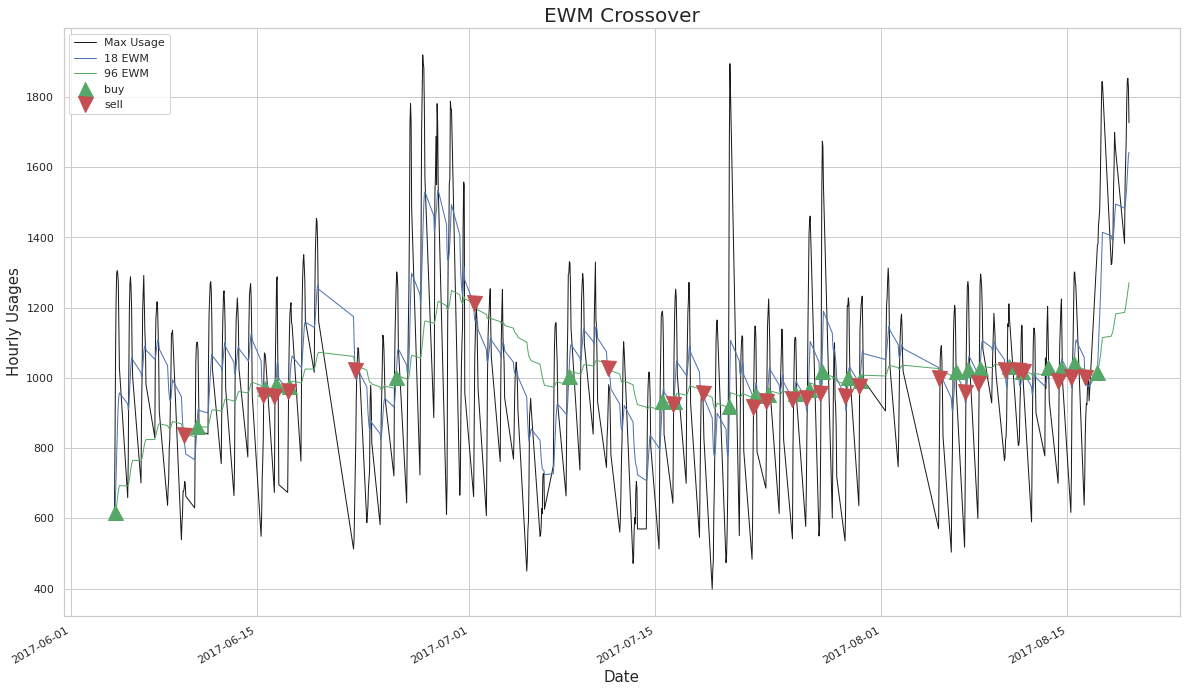

In [27]:
plt.figure(figsize = (20,12))

# plot close price, short-term and long-term moving averages 
mun_6['usage_max'].plot(color = 'k', lw = 1, label = 'Max Usage')  
mun_6['18_ewm'].plot(color = 'b', lw = 1, label = '18 EWM') 
mun_6['96_ewm'].plot(color = 'g', lw = 1, label = '96 EWM')

# plot ‘buy’ and 'sell' signals
plt.plot(mun_6[mun_6["Buy_sell_pts"] == 1].index, 
         mun_6["18_ewm"][mun_6["Buy_sell_pts"] == 1], 
         "^", markersize = 15, color = "g", label = 'buy')
plt.plot(mun_6[mun_6["Buy_sell_pts"] == -1].index, 
         mun_6["18_ewm"][mun_6["Buy_sell_pts"] == -1], 
         "v", markersize = 15, color = "r", label = 'sell')
plt.ylabel('Hourly Usages', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('EWM Crossover', fontsize = 20)
plt.legend()
plt.show()

### 3.5. Features based on time window: Bollinger Bands

Calculate enter and exit points depending on overbought and oversold conditions (outliers).
https://medium.datadriveninvestor.com/bollinger-bands-for-identifying-overbought-and-oversold-conditions-in-market-python-ed26380b91d3

In [28]:
# calculate simple moving average (SMA), std, upper (+2*std) and lower bands (-2*std)
mun_6["18_sma"] = mun_6["usage_max"].rolling(18).mean()
mun_6["18_std"] = mun_6["usage_max"].rolling(18).std()
mun_6["18_sma_upband"] = mun_6["18_sma"] + 2*mun_6["18_std"]
mun_6["18_sma_dwnband"] = mun_6["18_sma"] - 2*mun_6["18_std"]
mun_6.tail()

,usage_max,date_month,date_day,date_week_of_year,date_weekday,Diff_h2h,Diff_d2d,Diff_w2w,Perc_change_h2h,Perc_change_d2d,Perc_change_w2w,18_ewm,96_ewm,Buy_sell_pts,Ewm_diff,18_sma,18_std,18_sma_upband,18_sma_dwnband
timestamp,,,,,,,,,,,,,,,,,,,
2017-08-19 12:00:00,1787,8,19,33,6,10900.0,24200.0,71000.0,6.495828,15.663430,65.923863,1549.915527,1224.437442,0.0,325.478084,1590.722222,174.141864,1939.005951,1242.438494
2017-08-19 13:00:00,1845,8,19,33,6,5800.0,20400.0,71700.0,3.245663,12.431444,63.563830,1580.977050,1237.232546,0.0,343.744504,1602.055556,183.967539,1969.990634,1234.120477
2017-08-19 14:00:00,1853,8,19,33,6,800.0,9200.0,66900.0,0.433604,5.224304,56.503378,1609.611045,1249.928783,0.0,359.682262,1607.166667,189.827863,1986.822393,1227.510940
2017-08-19 15:00:00,1829,8,19,33,6,-2400.0,-1500.0,67500.0,-1.295197,-0.813449,58.492201,1632.704619,1261.868395,0.0,370.836224,1606.333333,188.756924,1983.847182,1228.819485
2017-08-19 16:00:00,1727,8,19,33,6,-10200.0,-11600.0,60600.0,-5.576818,-6.294086,54.058876,1642.630449,1271.458738,0.0,371.171711,1599.888889,182.062978,1964.014846,1235.762932


In [29]:
# calculate start and exit points
mun_6['Enter_exit_pts'] = 0
mun_6.loc[mun_6["usage_max"] <= mun_6['18_sma_dwnband'], 'Enter_exit_pts'] = 1
mun_6.loc[mun_6["usage_max"] >= mun_6['18_sma_upband'], 'Enter_exit_pts']= -1

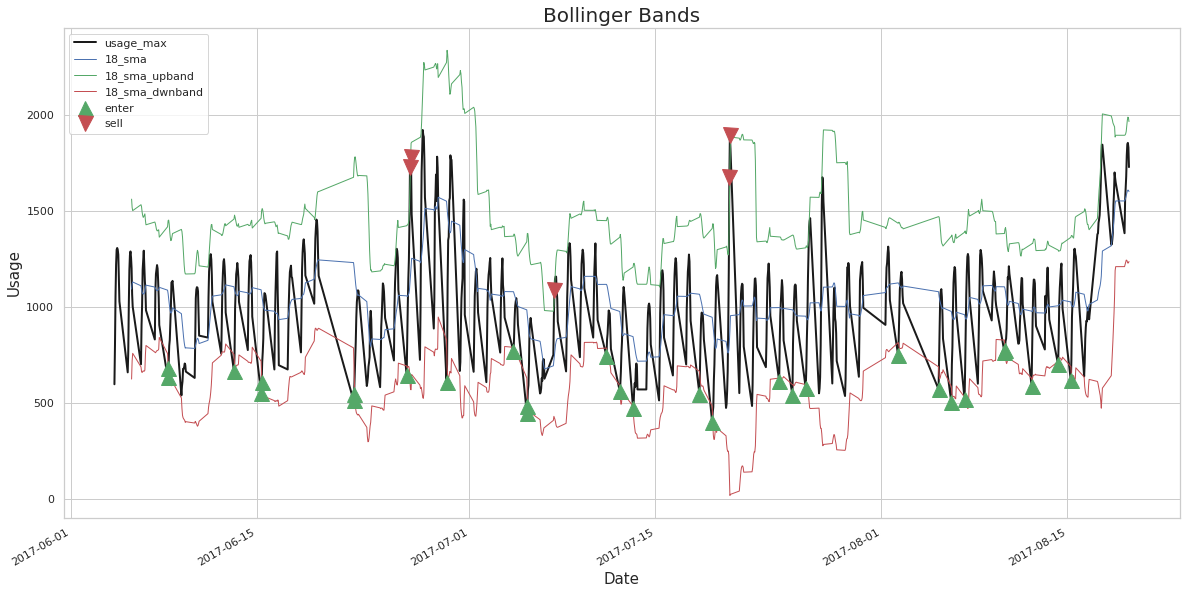

In [30]:
# plot bollinger bands
mun_6["usage_max"].plot(c = "k", figsize = (20,10), lw = 2)
mun_6["18_sma"].plot(c = "b", figsize = (20, 10), lw = 1)
mun_6["18_sma_upband"].plot(c = "g", figsize = (20, 10), lw = 1) 
mun_6["18_sma_dwnband"].plot(c = "r", figsize = (20, 10), lw = 1)

# plot ‘enter’ and 'exit' signals
plt.plot(mun_6[mun_6["Enter_exit_pts"] == 1].index, 
         mun_6["usage_max"][mun_6["Enter_exit_pts"] == 1], 
         "^", markersize = 15, color = "g", label = 'enter')
plt.plot(mun_6[mun_6["Enter_exit_pts"] == -1].index, 
         mun_6["usage_max"][mun_6["Enter_exit_pts"] == -1], 
         "v", markersize = 15, color = "r", label = 'sell')

plt.title("Bollinger Bands", fontsize = 20)
plt.ylabel("Usage",fontsize = 15 )
plt.xlabel("Date", fontsize = 15 )
plt.legend()
plt.show()

### 3.6. Features based on time window: Statistical measures

Calculate statistical metrics of short-term (1-day) past window.  
https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60

In [31]:
# construct time windows
x_list = []
for i in range(0, mun_6.shape[0] - 18, 1):
    xs = mun_6['usage_max'].values[i: i + 18]
    x_list.append(xs)

In [32]:
# drop first 18 elements
print("before: ", len(mun_6))
mun_6 = mun_6[18:]
print("after: ", len(mun_6))

before:  674
after:  656


In [33]:
# mean ("18_sma") and std ("18_std") are calculated before 

# avg absolute diff
mun_6['18_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x)))).values

# min
mun_6['18_min'] = pd.Series(x_list).apply(lambda x: x.min()).values

# max
mun_6['18_max'] = pd.Series(x_list).apply(lambda x: x.max()).values

# max-min diff
mun_6['18_maxmin_diff'] = mun_6['18_max'] - mun_6['18_min']

# median
mun_6['18_median'] = pd.Series(x_list).apply(lambda x: np.median(x)).values

# median abs dev 
mun_6['18_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x)))).values

# interquartile range
mun_6['18_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25)).values

# values above mean
mun_6['18_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean())).values

# number of peaks
mun_6['18_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0])).values

# skewness
mun_6['18_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x)).values

# kurtosis
mun_6['18_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x)).values

# energy
mun_6['18_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/18).values

### 3.7. Features based on time window: Statistical measures on fourier transform

Calculate statistical metrics of fourier transformed short-term (1-day) past window. 

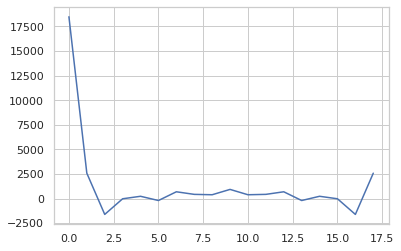

In [34]:
# an example of transformed time window to frequency domain
freq_domain = pd.Series(np.fft.fft(pd.Series(x_list[142])))
freq_domain.plot()
plt.show()

Some observations:

- The first value is unusually high. This is called as ‘DC component’ or ‘DC offset’ in electrical terminology.
- The wave signal is symmetric about the centre.

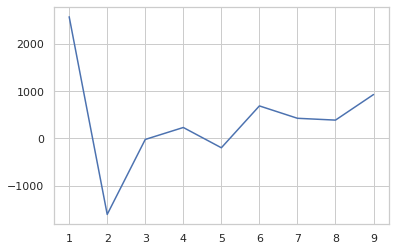

In [35]:
# trim initial values and symmetric part
freq_domain[1:10].plot()
plt.show()

In [36]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:10])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
mun_6['18_sma_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean()).values

# FFT std dev
mun_6['18_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std()).values

# FFT avg absolute diff
mun_6['18_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x)))).values

# FFT min
mun_6['18_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min()).values

# FFT max
mun_6['18_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max()).values

# FFT max-min diff
mun_6['18_maxmin_diff_fft'] = mun_6['18_max_fft'] - mun_6['18_min_fft']

# FFT median
mun_6['18_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x)).values

# FFT median abs dev 
mun_6['18_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x)))).values

# FFT Interquartile range
mun_6['18_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25)).values

# FFT values above mean
mun_6['18_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean())).values

# FFT number of peaks
mun_6['18_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0])).values

# FFT skewness
mun_6['18_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x)).values

# FFT kurtosis
mun_6['18_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x)).values

# FFT energy
mun_6['18_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/9).values

### 3.8. Features based on time window: Indices of significant points

Find significant points of short-term (1-day) past window and save them as new features. 

In [37]:
# index of max value in time domain
mun_6['18_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x)).values

# index of min value in time domain
mun_6['18_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x)).values

# absolute difference between above indices
mun_6['18_arg_diff'] = abs(mun_6['18_argmax'] - mun_6['18_argmin'])

# index of max value in frequency domain
mun_6['18_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:10])).values

# index of min value in frequency domain
mun_6['18_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:10])).values

# absolute difference between above indices
mun_6['18_arg_diff_fft'] = abs(mun_6['18_argmax_fft'] - mun_6['18_argmin_fft'])

In [38]:
mun_6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 656 entries, 2017-06-05 15:00:00 to 2017-08-19 16:00:00
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   usage_max           656 non-null    int64  
 1   date_month          656 non-null    int64  
 2   date_day            656 non-null    int64  
 3   date_week_of_year   656 non-null    int64  
 4   date_weekday        656 non-null    int64  
 5   Diff_h2h            656 non-null    float64
 6   Diff_d2d            656 non-null    float64
 7   Diff_w2w            578 non-null    float64
 8   Perc_change_h2h     656 non-null    float64
 9   Perc_change_d2d     656 non-null    float64
 10  Perc_change_w2w     578 non-null    float64
 11  18_ewm              656 non-null    float64
 12  96_ewm              656 non-null    float64
 13  Buy_sell_pts        656 non-null    float64
 14  Ewm_diff            656 non-null    float64
 15  18_sma              

In [39]:
# fill na's with mean in two columns
mun_6["Diff_w2w"].fillna(mun_6["Diff_w2w"].mean(), inplace=True)
mun_6["Perc_change_w2w"].fillna(mun_6["Perc_change_w2w"].mean(), inplace=True)

In [40]:
mun_6.describe()

,usage_max,date_month,date_day,date_week_of_year,date_weekday,Diff_h2h,Diff_d2d,Diff_w2w,Perc_change_h2h,Perc_change_d2d,...,18_peak_count_fft,18_skewness_fft,18_kurtosis_fft,18_energy_fft,18_argmax,18_argmin,18_arg_diff,18_argmax_fft,18_argmin_fft,18_arg_diff_fft
count,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,...,656.000000,656.000000,656.000000,6.560000e+02,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000
mean,1040.818598,6.911585,15.102134,27.948171,4.057927,80.182927,1393.292683,2589.965398,1.951039,7.233473,...,2.948171,1.581688,1.480875,9.561751e+05,9.189024,7.640244,7.841463,1.032012,2.859756,2.727134
std,292.492123,0.756521,8.061799,3.122007,1.981517,18642.740125,33080.752700,38836.558322,18.005063,39.762882,...,0.898037,0.432660,1.282249,7.153519e+05,5.629334,5.224589,4.384482,1.889435,1.329120,1.156566
min,399.000000,6.000000,1.000000,23.000000,1.000000,-127000.000000,-84900.000000,-122000.000000,-69.741900,-55.689177,...,0.000000,0.045099,-1.366512,2.861387e+05,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,834.000000,6.000000,9.000000,25.000000,2.000000,-5925.000000,-20925.000000,-21225.000000,-5.184349,-18.832316,...,2.000000,1.257661,0.371970,5.390903e+05,4.000000,3.000000,4.000000,0.000000,2.000000,2.000000
50%,1050.500000,7.000000,15.000000,28.000000,4.000000,2600.000000,650.000000,2589.965398,2.756647,0.600903,...,3.000000,1.673063,1.681524,6.841899e+05,10.000000,7.000000,6.000000,0.000000,3.000000,2.000000
75%,1193.250000,7.000000,22.000000,30.000000,6.000000,10125.000000,21000.000000,28025.000000,11.271073,22.251721,...,4.000000,1.919502,2.532597,9.374739e+05,14.000000,12.000000,13.000000,2.000000,4.000000,4.000000
max,1920.000000,8.000000,30.000000,33.000000,7.000000,47900.000000,142200.000000,115500.000000,60.683761,356.390977,...,4.000000,2.365920,3.815333,3.677659e+06,17.000000,17.000000,17.000000,7.000000,7.000000,6.000000


### 3.9. Creating training testing datasets

In [41]:
# train-test split
train = mun_6[:"2017-08-04"]
test = mun_6["2017-08-05":]
print ("train size: ", len(train))
print ("test size: ", len(test))

train size:  514
test size:  142


In [42]:
# X-y splits
y_train = train["usage_max"].values.reshape(-1,1)
X_train = train.drop(columns=["usage_max"])

y_test = test["usage_max"].values.reshape(-1,1)
X_test = test.drop(columns=["usage_max"])

# 4. REGRESSION MODELS

#### 4.1. Baseline: Logistic regression

R2 score:  0.8988245549296355
MSE score:  9128.44366197183


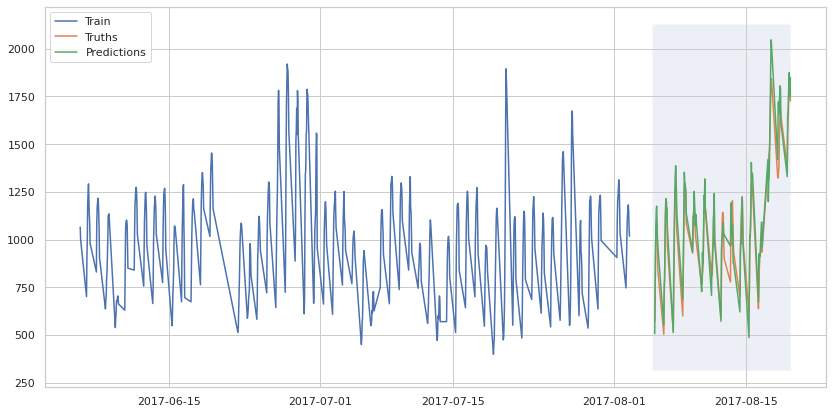

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# standardization
feature_scaler = StandardScaler()
feature_scaler.fit(X_train)
X_train_scaled = feature_scaler.transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

label_scaler = StandardScaler()
label_scaler.fit(y_train)
y_train_scaled = label_scaler.transform(y_train)
y_test_scaled = label_scaler.transform(y_test)

# ridge regression model
baseline_model = Ridge(random_state = 21)
baseline_model.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = baseline_model.predict(X_test_scaled)

# revert scaling of predictions
y_pred = np.round(label_scaler.inverse_transform(y_pred_scaled))
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results=list()
results.append({"model":"ridge_default", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["ridge_default_preds"] = y_pred

# plot predictions along with truth values
plt.figure(figsize=(14,7))
plt.plot(train["usage_max"], label="Train")
plt.plot(test["usage_max"], label="Truths")
plt.plot(test["ridge_default_preds"], label="Predictions")
plt.legend(loc="best")
plt.fill_betweenx(plt.gca().get_ylim(), pd.to_datetime("2017-08-05"), mun_6.index[-1],
                 alpha=.1, zorder=-1);

The best parameters are {'alpha': 9.547716114208066} with a score of 0.7709
R2 score:  0.9099867696513209
MSE score:  8121.345070422535


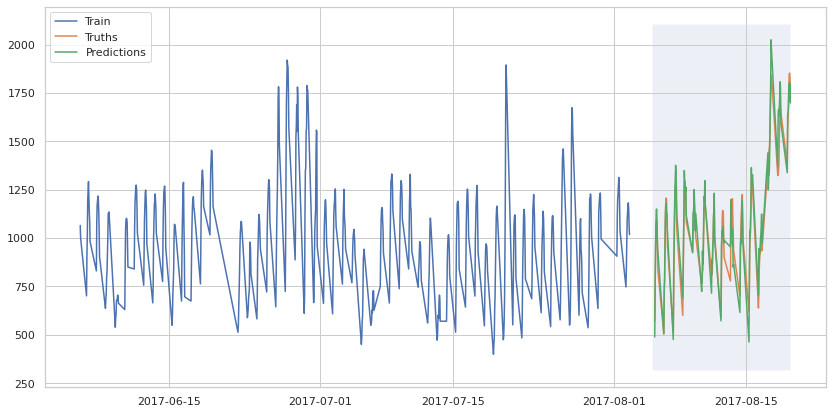

In [44]:
# hyperparameter search
from sklearn.model_selection import GridSearchCV

# parameters 
parameters = {
                "alpha": np.logspace(-5, 2, 200),          
}

# find best model
grid_ridge = GridSearchCV(estimator=baseline_model, param_grid=parameters, cv=10, n_jobs=-1)
grid_ridge.fit(X_train_scaled, y_train_scaled)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid_ridge.best_params_, grid_ridge.best_score_))

# prediction results
y_pred_scaled = grid_ridge.predict(X_test_scaled)

# revert scaling of predictions
y_pred = np.round(label_scaler.inverse_transform(y_pred_scaled))
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results.append({"model":"ridge_best", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["ridge_best_preds"] = y_pred

# plot predictions along with truth values
plt.figure(figsize=(14,7))
plt.plot(train["usage_max"], label="Train")
plt.plot(test["usage_max"], label="Truths")
plt.plot(test["ridge_best_preds"], label="Predictions")
plt.legend(loc="best")
plt.fill_betweenx(plt.gca().get_ylim(), pd.to_datetime("2017-08-05"), mun_6.index[-1],
                 alpha=.1, zorder=-1);

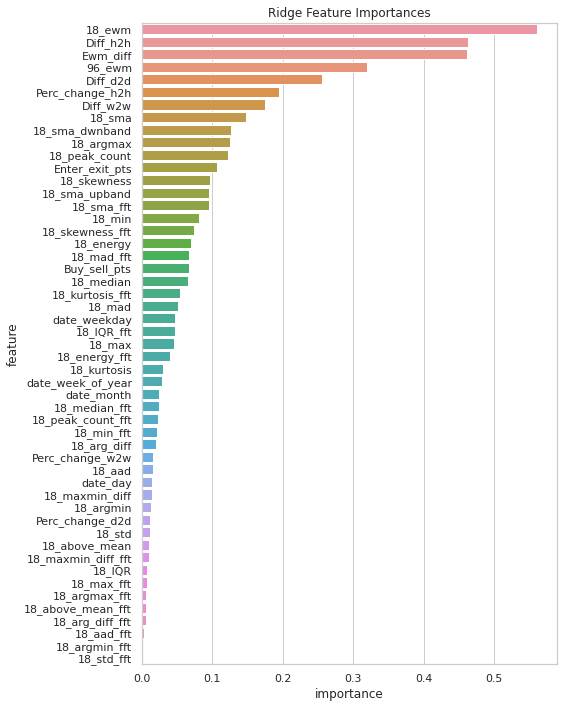

In [45]:
# Plot feature importances
importances = abs(grid_ridge.best_estimator_.coef_.ravel())
features = X_train.columns.tolist()
importance_df = pd.DataFrame(list(zip(features,importances)), 
                             columns=["feature","importance"]).sort_values(by="importance", 
                                                                           ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(
    x="importance",
    y="feature",
    data = importance_df
)
plt.title('Ridge Feature Importances')
plt.tight_layout()

### 4.2. Alternative: XGBoost regressor

In [46]:
#Importing XGBM Classifier 
import xgboost as xgb

#creating an extreme Gradient boosting instance
xgb_model = xgb.XGBRegressor(
                   #early_stopping_rounds=100,
                   random_state=0, 
                   #tree_method='gpu_hist', 
                   verbosity=0
                )

xgb_model.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = xgb_model.predict(X_test_scaled)

# revert scaling of predictions
y_pred = np.round(label_scaler.inverse_transform(y_pred_scaled))
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results.append({"model":"xgb_default", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["xgb_default_preds"] = y_pred

R2 score:  0.8098109503637143
MSE score:  17159.598591549297


In [47]:
# hyperparameter search
from sklearn.model_selection import RandomizedSearchCV

# parameters 
parameters = {'max_depth': list(range(4, 10)),
              'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
              'n_estimators': list(range(50, 1000)),
              'gamma': list(np.linspace(0, 1)),
              'min_child_weight': list(range(1, 50)),
              'max_delta_step': list(range(0, 10)),
              "max_leaves": list(range(10, 90)),
              'subsample': list(np.linspace(0.4, 1, 10)),
              'reg_alpha': list(np.linspace(0, 1)),
              'reg_lambda': list(np.linspace(0, 1)),
              'colsample_bytree' :list(np.linspace(0.4, 1, 10)),
              },

# grid search for parameters
grid_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=parameters, 
                              cv=10, n_iter=100)
grid_xgb.fit(X_train_scaled, y_train_scaled)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid_xgb.best_params_, grid_xgb.best_score_))

# prediction results
y_pred_scaled = grid_xgb.predict(X_test_scaled)

# revert scaling of predictions
y_pred = np.round(label_scaler.inverse_transform(y_pred_scaled))
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results.append({"model":"xgb_best", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["xgb_best_preds"] = y_pred

The best parameters are {'subsample': 0.8666666666666667, 'reg_lambda': 0.5102040816326531, 'reg_alpha': 0.8775510204081632, 'n_estimators': 351, 'min_child_weight': 28, 'max_leaves': 25, 'max_depth': 7, 'max_delta_step': 1, 'learning_rate': 0.09209483403998553, 'gamma': 0.08163265306122448, 'colsample_bytree': 0.6000000000000001} with a score of 0.8135
R2 score:  0.8644290607126992
MSE score:  12231.739436619719


R2 score:  0.8644290607126992
MSE score:  12231.739436619719


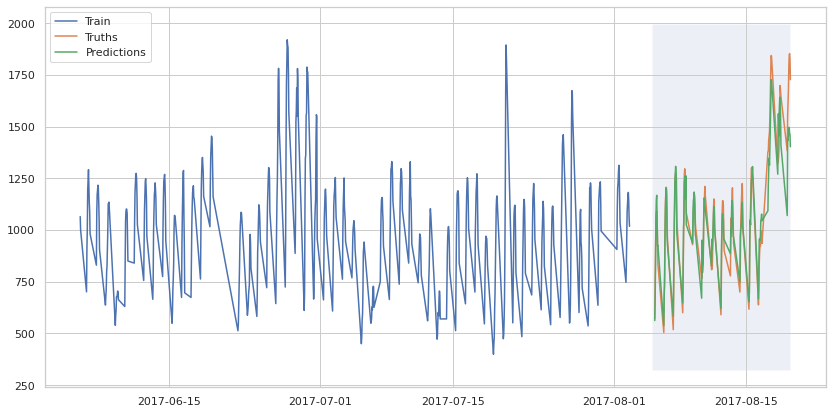

In [48]:
# extend n_estimators to 10000
best_params_dict=grid_xgb.best_estimator_.get_params()
best_params_dict["n_estimators"]=10000
extented_xgb = xgb.XGBRegressor().set_params(**best_params_dict)
extented_xgb.fit(X_train_scaled, y_train_scaled)

# prediction results
y_pred_scaled = grid_xgb.predict(X_test_scaled)

# revert scaling of predictions
y_pred = np.round(label_scaler.inverse_transform(y_pred_scaled))
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results.append({"model":"xgb_extended", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["xgb_extended_preds"] = y_pred

# plot predictions along with truth values
plt.figure(figsize=(14,7))
plt.plot(train["usage_max"], label="Train")
plt.plot(test["usage_max"], label="Truths")
plt.plot(test["xgb_extended_preds"], label="Predictions")
plt.legend(loc="best")
plt.fill_betweenx(plt.gca().get_ylim(), pd.to_datetime("2017-08-05"), mun_6.index[-1],
                 alpha=.1, zorder=-1);

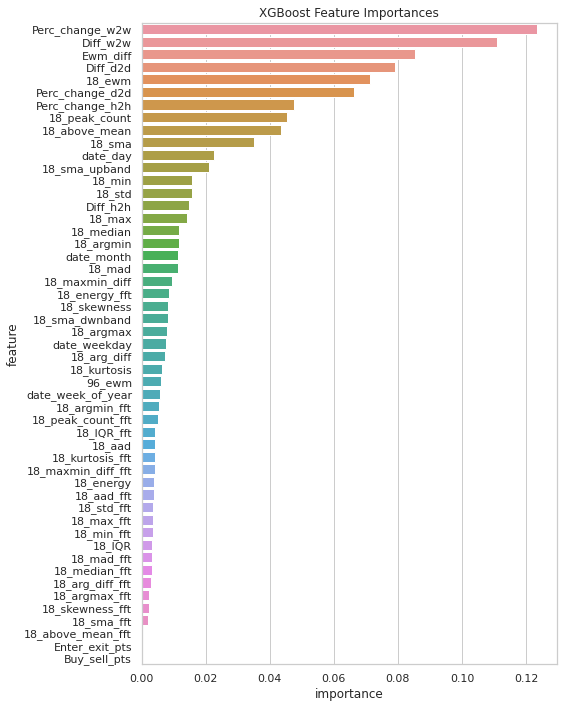

In [49]:
# Plot feature importances
importances = grid_xgb.best_estimator_.feature_importances_
features = X_train.columns.tolist()
importance_df = pd.DataFrame(list(zip(features,importances)), 
                             columns=["feature","importance"]).sort_values(by="importance", 
                                                                           ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(
    x="importance",
    y="feature",
    data = importance_df
)
plt.title('XGBoost Feature Importances')
plt.tight_layout()

# 5. SEQUENTIAL MODELS

Seasonal ARIMA, Prophet and LSTM are implemented here, only on single attribute "usage_max" without using the ones extracted in feature engineering section (univariate prediction). This section is based on a previous work by me and my friend :  
https://www.kaggle.com/aysenur95/time-series-analysing-forecasting

### 5.1. Seasonal model: SARIMAX
The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. **D** must be an integer indicating the integration order of the process, while **P** and **Q** may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included). **s** is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. In our case we will try **18 as daily** and **96 as weekly** periodicty.

In [50]:
import statsmodels.api as sm
warnings.filterwarnings("ignore", category = sm.tools.sm_exceptions.ValueWarning)
import itertools

# define search spaces as list of tuples
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [18, 96]
pdq = list(itertools.product(p, d, q))
PDQs = list(itertools.product(P, D, Q, s))
aic_min=np.inf
param_min=0
param_seasonal_min=0


#“grid search” to find the optimal set of parameters that yields 
# the best performance for our model.
for param in pdq:
    for param_seasonal in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(mun_6["usage_max"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            sarimax_results = mod.fit(disp=False)
            aic_current=sarimax_results.aic
            print('SARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, aic_current))
            if(aic_current < aic_min):
                aic_min=aic_current
                param_min=param
                param_seasonal_min=param_seasonal
        except:
            continue
            
print(aic_min, "-->>", param_min,"---",param_seasonal_min)

SARIMA(0, 0, 0)x(0, 0, 0, 18)4 - AIC:11012.121462240684
SARIMA(0, 0, 0)x(0, 0, 0, 96)4 - AIC:11012.121462240684
SARIMA(0, 0, 0)x(0, 0, 1, 18)4 - AIC:10100.327479142106
SARIMA(0, 0, 0)x(0, 0, 1, 96)4 - AIC:8976.811861444734
SARIMA(0, 0, 0)x(0, 1, 0, 18)4 - AIC:9211.699117831433
SARIMA(0, 0, 0)x(0, 1, 0, 96)4 - AIC:8336.24875682859
SARIMA(0, 0, 0)x(0, 1, 1, 18)4 - AIC:8834.113995905991
SARIMA(0, 0, 0)x(0, 1, 1, 96)4 - AIC:6700.013247748582
SARIMA(0, 0, 0)x(1, 0, 0, 18)4 - AIC:9220.60527750255
SARIMA(0, 0, 0)x(1, 0, 0, 96)4 - AIC:8345.216191898291
SARIMA(0, 0, 0)x(1, 0, 1, 18)4 - AIC:9099.642087277476
SARIMA(0, 0, 0)x(1, 0, 1, 96)4 - AIC:8145.0916486684955
SARIMA(0, 0, 0)x(1, 1, 0, 18)4 - AIC:8905.479271653656
SARIMA(0, 0, 0)x(1, 1, 0, 96)4 - AIC:6801.257457395529
SARIMA(0, 0, 0)x(1, 1, 1, 18)4 - AIC:8786.23418430534
SARIMA(0, 0, 0)x(1, 1, 1, 96)4 - AIC:6701.306486795145
SARIMA(0, 0, 1)x(0, 0, 0, 18)4 - AIC:10210.490158098117
SARIMA(0, 0, 1)x(0, 0, 0, 96)4 - AIC:10210.490158098117
SARIMA(

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(0, 0, 1)x(1, 0, 1, 18)4 - AIC:8655.614319482778
SARIMA(0, 0, 1)x(1, 0, 1, 96)4 - AIC:7744.878760104114
SARIMA(0, 0, 1)x(1, 1, 0, 18)4 - AIC:8522.230326415278
SARIMA(0, 0, 1)x(1, 1, 0, 96)4 - AIC:6488.111427094229
SARIMA(0, 0, 1)x(1, 1, 1, 18)4 - AIC:8370.517200867413
SARIMA(0, 0, 1)x(1, 1, 1, 96)4 - AIC:6369.655427841177
SARIMA(0, 1, 0)x(0, 0, 0, 18)4 - AIC:8696.61240093179
SARIMA(0, 1, 0)x(0, 0, 0, 96)4 - AIC:8696.61240093179
SARIMA(0, 1, 0)x(0, 0, 1, 18)4 - AIC:8433.015347412622
SARIMA(0, 1, 0)x(0, 0, 1, 96)4 - AIC:7458.48507679651
SARIMA(0, 1, 0)x(0, 1, 0, 18)4 - AIC:8736.763511072484
SARIMA(0, 1, 0)x(0, 1, 0, 96)4 - AIC:7850.9910710232325
SARIMA(0, 1, 0)x(0, 1, 1, 18)4 - AIC:8279.060924510892
SARIMA(0, 1, 0)x(0, 1, 1, 96)4 - AIC:6291.372928100052
SARIMA(0, 1, 0)x(1, 0, 0, 18)4 - AIC:8445.158796466083
SARIMA(0, 1, 0)x(1, 0, 0, 96)4 - AIC:7471.266885093788
SARIMA(0, 1, 0)x(1, 0, 1, 18)4 - AIC:8434.401566019047
SARIMA(0, 1, 0)x(1, 0, 1, 96)4 - AIC:7460.163895941572
SARIMA(0, 1,

In [51]:
# fit model with best parameters
model = sm.tsa.statespace.SARIMAX(mun_6["usage_max"],
                                order=param_min,
                                seasonal_order=param_seasonal_min,
                                enforce_stationarity=False,
                                enforce_invertibility=False)


sarimax_results = model.fit(disp=False)
sarimax_results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6881,0.041,16.912,0.000,0.608,0.768
ma.L1,0.2949,0.054,5.504,0.000,0.190,0.400
ma.S.L96,-1.0004,0.047,-21.240,0.000,-1.093,-0.908
sigma2,3.074e+04,1.53e-06,2.01e+10,0.000,3.07e+04,3.07e+04


**Static** method uses previous truth values in each steps of prediction while **dynamic** method uses previous predicted values. Normally, dynamic method is the valid way to modeling but we used static method here to allow comparison with classical machine learning models. Because extracted features above are based on truth values.

R2 score:  0.654671479746388
MSE score:  31156.88732394366


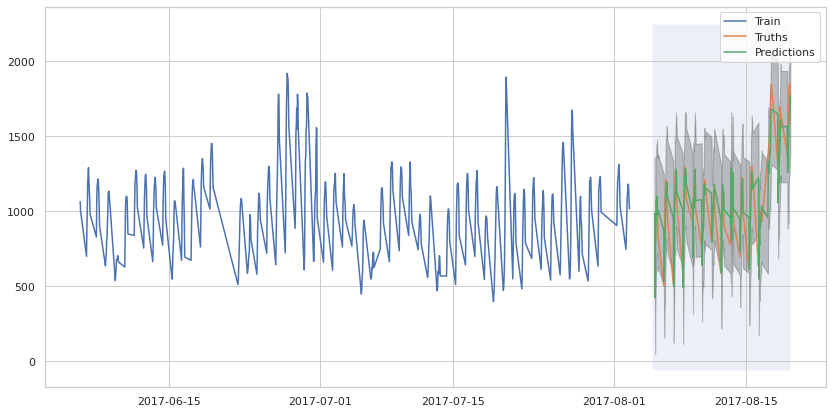

In [52]:
# get prediction with confidence intervals
y_pred = sarimax_results.get_prediction(start='2017-08-05', dynamic=False)
y_pred_ci = y_pred.conf_int()
y_pred = np.round(y_pred.predicted_mean.values.reshape(-1,1))

# calculate scores
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results.append({"model":"sarımax", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["sarimax_preds"] = y_pred

# plot predictions along with truth values
plt.figure(figsize=(14,7))
plt.plot(train["usage_max"], label="Train")
plt.plot(test["usage_max"], label="Truths")
plt.plot(test["sarimax_preds"], label="Predictions")
plt.fill_between(y_pred_ci.index,
                y_pred_ci.iloc[:, 0],
                y_pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.legend(loc="best")
plt.fill_betweenx(plt.gca().get_ylim(), pd.to_datetime("2017-08-05"), mun_6.index[-1],
                 alpha=.1, zorder=-1);

### 5.2. Seasonal model: PROPHET
Generally Prophet performs better than ARIMA since Prophet considers non-linear relationship between elements of time series (trend, nested seasonality, residual). It also considers holiday effects and is robust to missing data and outliers. 

Initial log joint probability = -23.2745
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       1084.81    0.00111952       98.5174   1.186e-05       0.001      112  LS failed, Hessian reset 
      99       1085.91     0.0106847       158.023      0.0375           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        1087.1    0.00116908       132.565   1.411e-05       0.001      215  LS failed, Hessian reset 
     199       1087.86    0.00183336       78.5274           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       1090.23   0.000348274       89.1401   4.261e-06       0.001      429  LS failed, Hessian reset 
     275       1090.31   0.000178491       68.9488   2.539e-06       0.001      495  LS failed, Hessian reset 
     299       1090.32   4.46406e-06       52.9847           1   

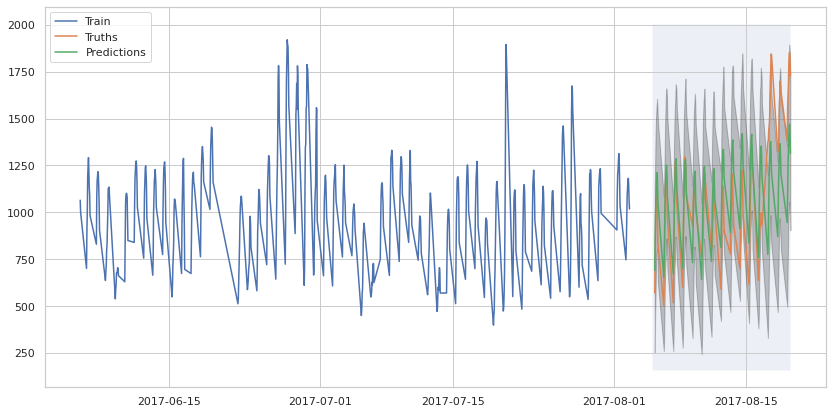

In [53]:
from fbprophet import Prophet

# build dataframe with necesarry renaming
df_prophet = pd.DataFrame(zip(mun_6.index.values, mun_6["usage_max"].values),
                         columns=["ds", "y"])

# run model
model_prophet = Prophet(interval_width=0.95)
model_prophet.fit(df_prophet)

future_df = model_prophet.make_future_dataframe(periods=0)
results_prophet = model_prophet.predict(future_df)
y_pred = results_prophet[-142:].set_index("ds")
y_pred_ci = y_pred[["yhat_lower", "yhat_upper"]]
y_pred = np.round(y_pred["yhat"].values)

# calculate scores
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results.append({"model":"prophet", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["prophet_preds"] = y_pred

# plot predictions along with truth values
plt.figure(figsize=(14,7))
plt.plot(train["usage_max"], label="Train")
plt.plot(test["usage_max"], label="Truths")
plt.plot(test["prophet_preds"], label="Predictions")
plt.fill_between(y_pred_ci.index,
                y_pred_ci.iloc[:, 0],
                y_pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.legend(loc="best")
plt.fill_betweenx(plt.gca().get_ylim(), pd.to_datetime("2017-08-05"), mun_6.index[-1],
                 alpha=.1, zorder=-1);

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

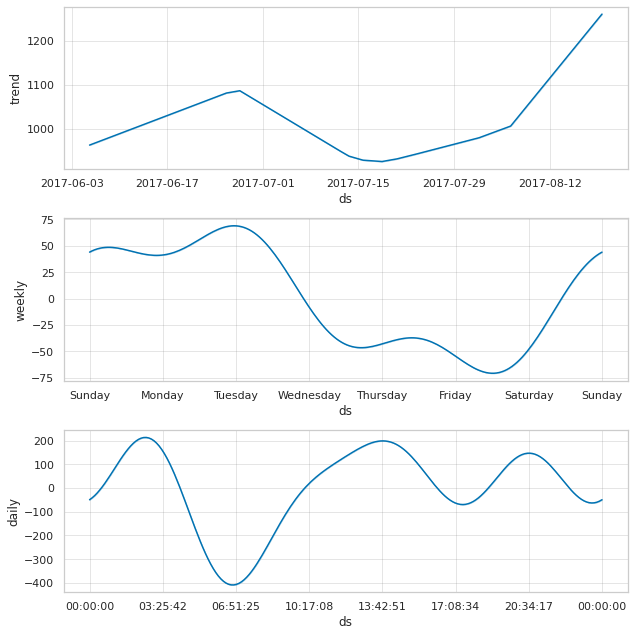

In [54]:
model_prophet.plot_components(results_prophet);

### 5.3. Deep learning model: LSTM

This is not out-of-sample prediction, we first fit on train and then make predictions on test dataset. For each prediction, use truth values, not forecasted values in other words static predictions.

In [55]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
from sklearn.preprocessing import MinMaxScaler

# Define LSTM model
model_lstm = models.Sequential()
model_lstm.add(layers.LSTM(input_shape=(18, 1), units=50, activation='relu', 
                           return_sequences=False))
model_lstm.add(layers.Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

We create X,y for train, since the data has daily seasnoality length=18. We will use **x_list** we counstructed before since it contains sequences for the first 18 values.

In [56]:
# normalize values
x_list_scaled = []
for sequence in x_list:
    x_list_scaled.append(label_scaler.transform(sequence.reshape(-1,1)))

# train-test split
X_train_sequences = np.array(x_list_scaled[:-142])
# y_train_scaled is already defined above
X_test_seqeunces = np.array(x_list_scaled[-142:])
# y_test_scaled is already defined above


2021-11-05 16:39:06.124981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


R2 score:  0.24929828687936906
MSE score:  67731.23943661971


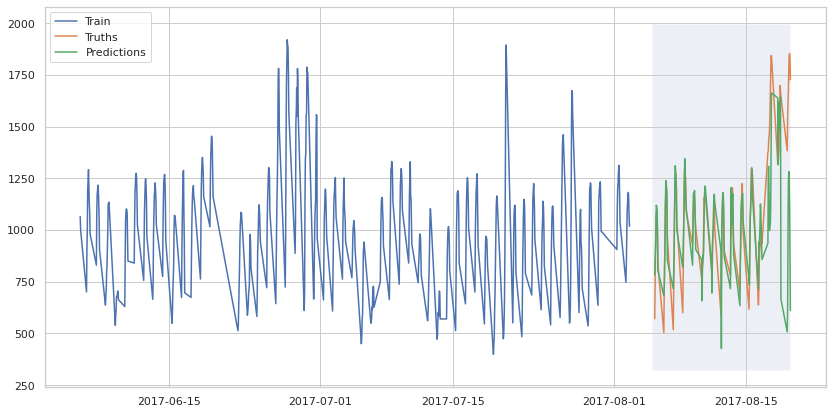

In [57]:
model_lstm.fit(X_train_sequences, y_train_scaled, epochs=500, batch_size=32, verbose=0)
pred_lstm = model_lstm.predict(X_test_seqeunces)

# revert scaling of predictions
y_pred = np.round(label_scaler.inverse_transform(pred_lstm))
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE score: ", mean_squared_error(y_test, y_pred))

# save results
results.append({"model":"lstm", 
                "R2":r2_score(y_test, y_pred), 
                "MSE":mean_squared_error(y_test, y_pred)})
test["lstm_preds"] = y_pred

# plot predictions along with truth values
plt.figure(figsize=(14,7))
plt.plot(train["usage_max"], label="Train")
plt.plot(test["usage_max"], label="Truths")
plt.plot(test["lstm_preds"], label="Predictions")
plt.legend(loc="best")
plt.fill_betweenx(plt.gca().get_ylim(), pd.to_datetime("2017-08-05"), mun_6.index[-1],
                 alpha=.1, zorder=-1);

# 6. RESULTS

In [58]:
# print results
results_df = pd.DataFrame(results)
results_df["R2"] = np.round(results_df["R2"], 4)
results_df["MSE"] = np.round(results_df["MSE"], 2)
results_df

,model,R2,MSE
0,ridge_default,0.8988,9128.44
1,ridge_best,0.9100,8121.35
2,xgb_default,0.8098,17159.60
3,xgb_best,0.8644,12231.74
4,xgb_extended,0.8644,12231.74
5,sarımax,0.6547,31156.89
6,prophet,0.4403,50498.13
7,lstm,0.2493,67731.24


- Best score is the baseline model Ridge Regressor since we did heavy feature engineering and it works very well. It is possible to improve this model with handling overfitting by dimensionality reduction. 
- Ridge classifier is even better than XGBoost and ARIMA. Because it behaves like already autoregressive and moving average model by calculating sum of statistics of lagged values.
- Generally Prophet is better than SARIMAX because it handles seasonality and outliers automatically but in our case the opposite is true owing to the tuning of SARIMAX by gridsearch. 
- It is possible to improve SARIMAX by using exagenous (features) variables. Also, extending search spaces for parameters and examining ACF and PACF plots may work.
- LSTM is worst model because it's not tuned and probably sequence length is not enough.
- Implementing dynamic predictions is the scientifically right way but we choose static one to compare models to baseline model. (Though, it's possible to implement baseline model in a dynamic way.)